Running initial simulation...


c:\ProgramData\Anaconda3\envs\bec_optimization\lib\site-packages\numpy\lib\_polynomial_impl.py:657: RuntimeWarning: invalid value encountered in divide
  lhs /= scale
2024-07-08 17:19:44,603 - WARNING - Could not calculate slope: SVD did not converge in Linear Least Squares


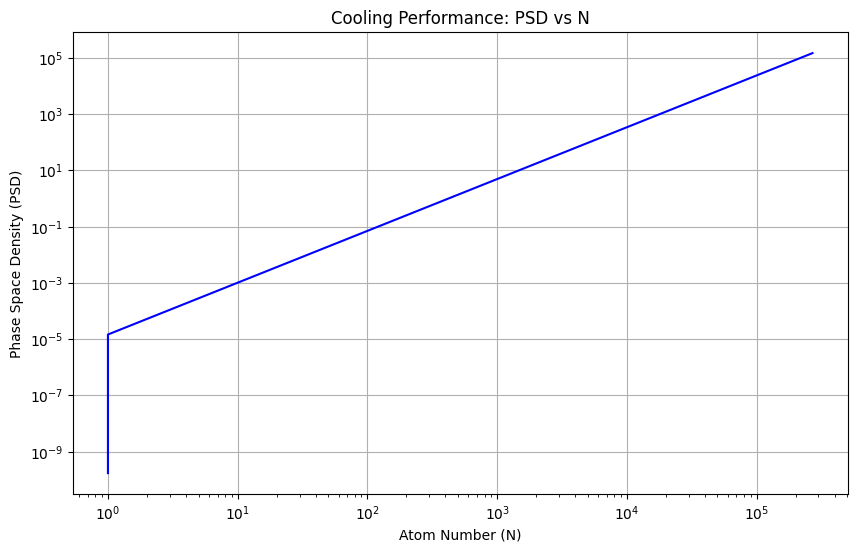

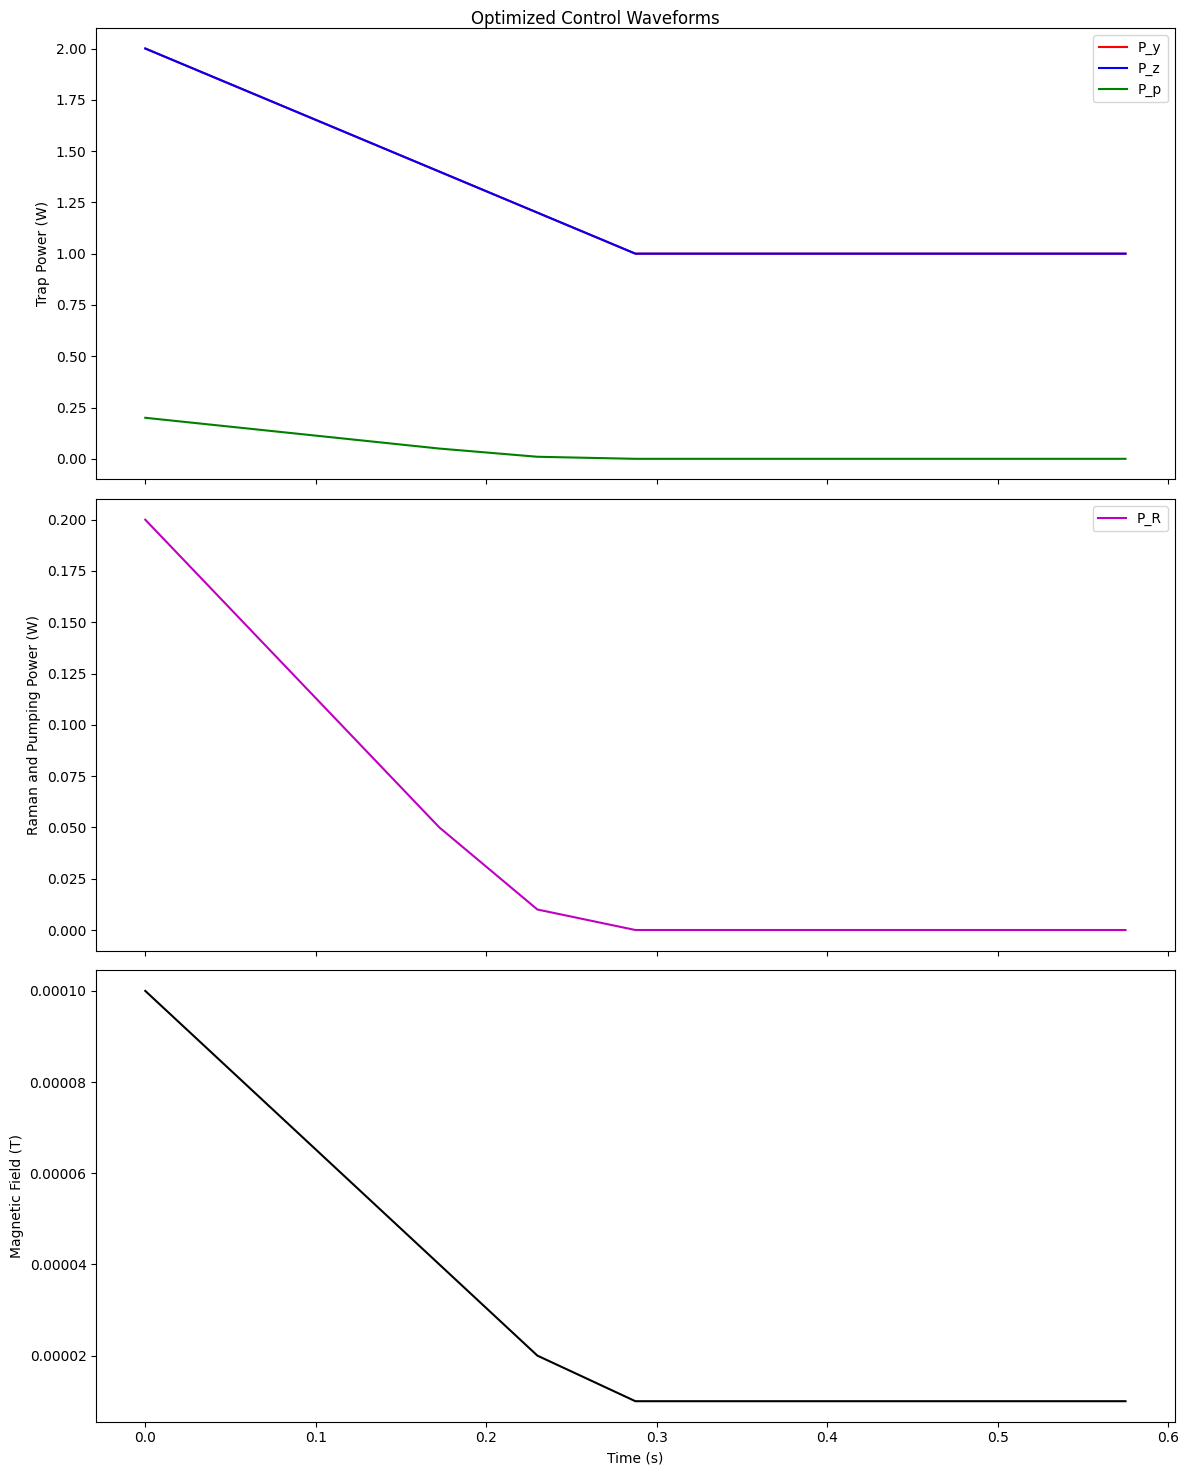

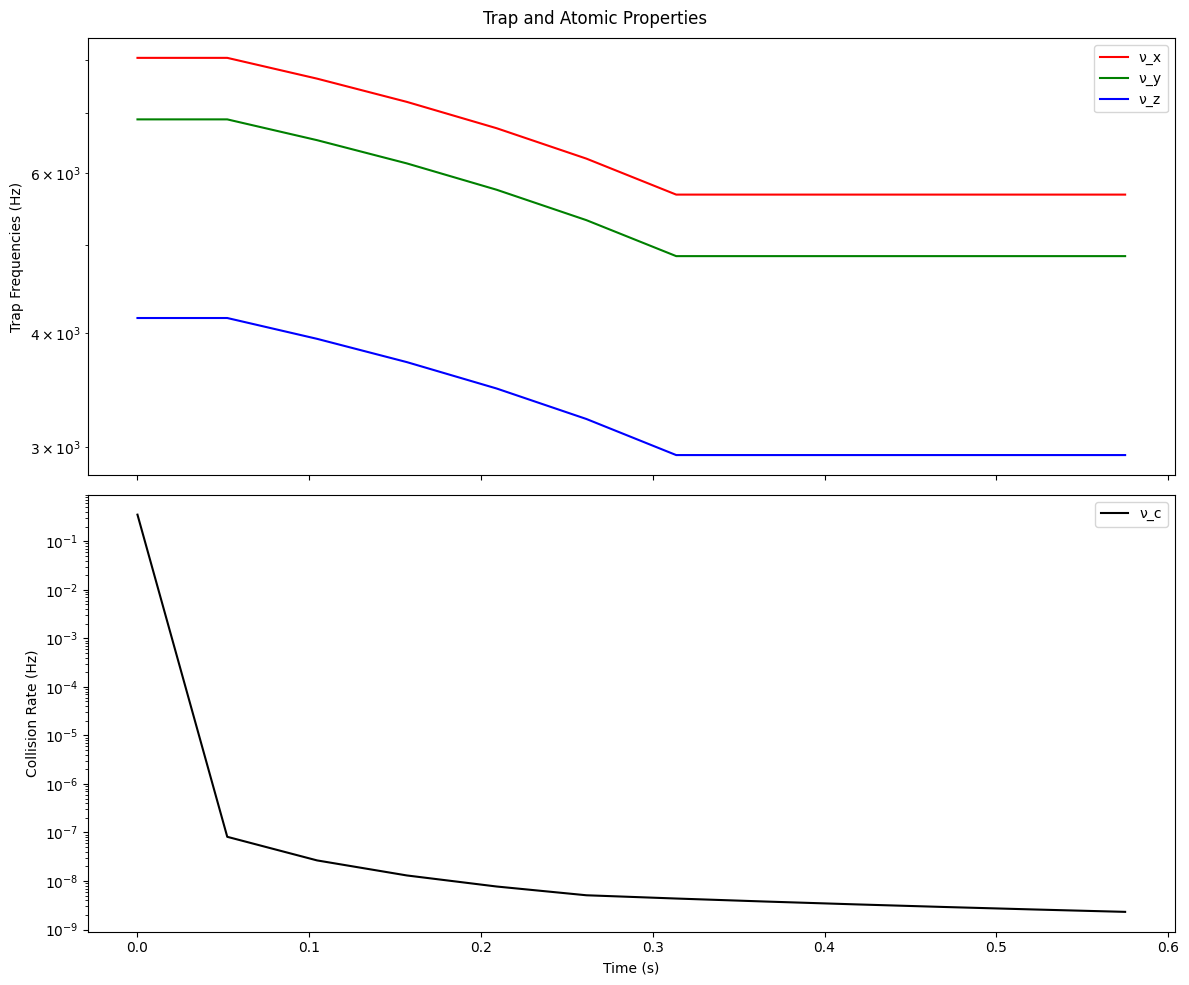

Final Temperature: 83102.12 μK
Final Atom Number: 1.00e+00
Final PSD: 7.03e-11
Estimated Condensate Fraction: 0.0%
Starting optimization process...


Optimization Progress: 100%|██████████| 1/1 [00:40<00:00, 40.64s/it]
2024-07-08 17:33:34,451 - INFO - Iteration 1: Best cost = -1.58e-35
2024-07-08 17:33:34,451 - INFO - Best parameters: P_y_max = 1.97e+00, P_z_max = 1.60e+00, P_R_max = 4.11e+01, P_p_max = 1.24e+00, B_z_max = 8.66e-04
2024-07-08 17:34:13,689 - INFO - Simulation results: N = 1.00e+00, T = 8.31e-02, PSD = 9.90e-12
Optimization Progress: 100%|██████████| 1/1 [00:43<00:00, 43.40s/it]
2024-07-08 17:48:04,216 - INFO - Iteration 2: Best cost = -1.58e-35
2024-07-08 17:48:04,217 - INFO - Best parameters: P_y_max = 1.97e+00, P_z_max = 1.60e+00, P_R_max = 4.11e+01, P_p_max = 1.24e+00, B_z_max = 8.66e-04
2024-07-08 17:48:43,718 - INFO - Simulation results: N = 1.00e+00, T = 8.31e-02, PSD = 9.90e-12
Optimization Progress:   0%|          | 0/1 [00:00<?, ?it/s]2024-07-08 18:02:33,815 - WARNING - Division by zero encountered in calculate_tilt. Returning 0.
2024-07-08 18:02:33,816 - WARNING - Division by zero encountered in calculate_t

In [1]:
import numpy as np
from scipy.constants import h, hbar, k, atomic_mass, mu_0, g, c, epsilon_0
from scipy.optimize import minimize
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Rubidium-87 properties
class Rb87:
    mass = 86.909180527 * atomic_mass
    wavelength_D1 = 794.979e-9  # meters
    wavelength_D2 = 780.241e-9  # meters
    gamma_D1 = 2 * np.pi * 5.746e6  # rad/s
    gamma_D2 = 2 * np.pi * 6.065e6  # rad/s
    a_s = 98 * 5.29e-11  # s-wave scattering length in meters
    g_F = 1/2  # Landé g-factor for F=2 state
    mu_B = 9.274e-24  # Bohr magneton in J/T
    
    # Calculate recoil energy for D1 transition
    Er_D1 = (h / wavelength_D1)**2 / (2 * mass)  # Joules
    
    # Calculate recoil velocity for D1 transition
    vr_D1 = h / (mass * wavelength_D1)  # m/s

    @classmethod
    def calculate_trap_frequency(cls, P, w0, wavelength):
        # Calculate trap frequency for a given beam power, waist, and wavelength
        U0 = 2 * cls.calculate_polarizability(wavelength) * P / (np.pi * c * epsilon_0 * w0**2)
        return np.sqrt(4 * U0 / (cls.mass * w0**2))

    @classmethod
    def calculate_polarizability(cls, wavelength):
        # This is a simplified calculation and might need to be adjusted for accuracy
        return 5.3e-39  # m^3, approximate value for 1064 nm

# Simulation parameters
N_atoms_initial = int(2.7e5)
T_initial = 300e-6
dt = 1e-4

class DipleTrap:
    def __init__(self, P_y, P_z, w_y, w_z, wavelength):
        self.P_y = P_y
        self.P_z = P_z
        self.w_y = w_y
        self.w_z = w_z
        self.wavelength = wavelength
        self.k = 2 * np.pi / wavelength
        self.alpha = 5.4e-39  # Polarizability of Rb87 at 1064 nm
        self.update_trap_frequencies()

    def update_trap_frequencies(self):
        U0_y = 2 * self.alpha * self.P_y / (np.pi * c * epsilon_0 * self.w_y**2)
        U0_z = 2 * self.alpha * self.P_z / (np.pi * c * epsilon_0 * self.w_z**2)
        self.omega_x = np.sqrt(4 * U0_y / (Rb87.mass * self.w_y**2) + 4 * U0_z / (Rb87.mass * self.w_z**2))
        self.omega_y = np.sqrt(4 * U0_z / (Rb87.mass * self.w_z**2))
        omega_z_squared = 4 * U0_y / (Rb87.mass * self.w_y**2) - 2 * g / self.w_y
        self.omega_z = np.sqrt(max(0, omega_z_squared))  # Ensure non-negative value
        
        logging.debug(f"Updated trap frequencies: omega_x = {self.omega_x:.2e}, "
                      f"omega_y = {self.omega_y:.2e}, omega_z = {self.omega_z:.2e}")

    def potential(self, x, y, z):
        U_y = -2 * self.alpha * self.P_y * np.exp(-2 * ((x**2 + z**2) / self.w_y**2)) / (np.pi * self.w_y**2 * c * epsilon_0)
        U_z = -2 * self.alpha * self.P_z * np.exp(-2 * ((x**2 + y**2) / self.w_z**2)) / (np.pi * self.w_z**2 * c * epsilon_0)
        U_gravity = Rb87.mass * g * z
        return U_y + U_z + U_gravity

    def force(self, x, y, z):
        F_x = -4 * self.alpha * self.P_y * x * np.exp(-2 * (x**2 + z**2) / self.w_y**2) / (np.pi * self.w_y**4 * c * epsilon_0) \
              -4 * self.alpha * self.P_z * x * np.exp(-2 * (x**2 + y**2) / self.w_z**2) / (np.pi * self.w_z**4 * c * epsilon_0)
        F_y = -4 * self.alpha * self.P_z * y * np.exp(-2 * (x**2 + y**2) / self.w_z**2) / (np.pi * self.w_z**4 * c * epsilon_0)
        F_z = -4 * self.alpha * self.P_y * z * np.exp(-2 * (x**2 + z**2) / self.w_y**2) / (np.pi * self.w_y**4 * c * epsilon_0) - Rb87.mass * g
        return np.column_stack((F_x, F_y, F_z))

    def calculate_tilt(self):
        denominator = self.omega_y**2 * self.w_y
        if denominator == 0:
            logging.warning("Division by zero encountered in calculate_tilt. Returning 0.")
            return 0
        tilt = np.arctan(g / denominator)
        logging.debug(f"Calculated tilt: {tilt:.2e}")
        return tilt

class LaserBeam:
    def __init__(self, power, w_x, w_y, wavelength):
        self.power = power
        self.w_x = w_x
        self.w_y = w_y
        self.wavelength = wavelength
        self.k = 2 * np.pi / wavelength

    def intensity(self, positions):
        x, y, _ = positions.T
        return 2 * self.power / (np.pi * self.w_x * self.w_y) * np.exp(-2 * (x**2 / self.w_x**2 + y**2 / self.w_y**2))

class AtomCloud:
    def __init__(self, N, T, trap):
        self.N = int(max(N, 1))  # Ensure at least one atom
        self.T = max(T, 1e-9)  # Ensure non-zero temperature (1 nK minimum)
        self.trap = trap
        self.positions = self.initialize_positions()
        self.velocities = self.initialize_velocities()
        self.light_shift = 0

    def initialize_positions(self):
        sigma = np.sqrt(k * self.T / (Rb87.mass * (2*np.pi*100)**2))
        return np.random.normal(0, sigma, (self.N, 3))

    def initialize_velocities(self):
        sigma_v = np.sqrt(k * self.T / Rb87.mass)
        return np.random.normal(0, sigma_v, (self.N, 3)) 

    def update(self, dt):
        forces = self.trap.force(self.positions[:, 0], self.positions[:, 1], self.positions[:, 2])
        self.N = int(self.N)
        self.velocities += forces * dt / Rb87.mass
        self.positions += self.velocities * dt

    def update_temperature(self):
        kinetic_energy = 0.5 * Rb87.mass * np.sum(self.velocities**2)
        self.T = max(2 * kinetic_energy / (3 * k * self.N), 1e-9)

    def apply_evaporation(self, trap_depth):
        tilt = self.trap.calculate_tilt()
        kinetic_energy = 0.5 * Rb87.mass * np.sum(self.velocities**2, axis=1)
        potential_energy = self.trap.potential(self.positions[:, 0], self.positions[:, 1], self.positions[:, 2])
        total_energy = kinetic_energy + potential_energy
        
        escape_prob = np.exp(-(trap_depth - total_energy) / (k * self.T)) * (1 + np.sin(tilt))
        mask = np.random.random(self.N) > escape_prob
        
        self.positions = self.positions[mask]
        self.velocities = self.velocities[mask]
        self.N = len(self.positions)  # Update N after evaporation

    def apply_light_shift(self, P_p, delta, sigma_minus_beam):
        I = sigma_minus_beam.intensity(self.positions)
        I_sat = 1.67
        self.light_shift = hbar * Rb87.gamma_D1**2 * I / (8 * delta * I_sat)

    def apply_gray_molasses(self, duration):
        cooling_rate = 1e-1
        self.T *= np.exp(-cooling_rate * duration)

    def apply_light_assisted_collisions(self, P_p, delta):
        n = self.calculate_density()
        K_2 = 1e-14 * P_p / (1 + 4 * delta**2 / Rb87.gamma_D1**2)  # Reduced collision rate
        loss_rate = K_2 * n * dt
        survival_prob = np.exp(-loss_rate)
        self.N = max(int(self.N * survival_prob), 1)  # Ensure at least one atom remains
        if self.N < len(self.positions):
            indices = np.random.choice(len(self.positions), self.N, replace=False)
            self.positions = self.positions[indices]
            self.velocities = self.velocities[indices]

    def apply_three_body_recombination(self):
        n = self.calculate_density()
        K_3 = 4e-30  # Reduced three-body loss coefficient
        loss_rate = K_3 * n**2 * dt
        survival_prob = np.exp(-loss_rate)
        self.N = max(int(self.N * survival_prob), 1)  # Ensure at least one atom remains
        if self.N < len(self.positions):
            indices = np.random.choice(len(self.positions), self.N, replace=False)
            self.positions = self.positions[indices]
            self.velocities = self.velocities[indices]
    
        heating_rate = K_3 * n**2 * (Rb87.a_s * hbar)**2 / (2 * Rb87.mass)
        self.T += heating_rate * dt
        self.update_temperature()

    def apply_photon_reabsorption_heating(self, P_p, delta):
        n = self.calculate_density()
        reabsorption_prob = n * 3 * Rb87.wavelength_D1**2 / (2 * np.pi)
        scattering_rate = P_p / (1 + 4 * delta**2 / Rb87.gamma_D1**2)
        heating_rate = reabsorption_prob * scattering_rate * 2 * Rb87.Er_D1 / (3 * k)
        self.T += heating_rate * dt

    def apply_magnetic_field(self, B_z):
        # Calculate the Zeeman shift
        zeeman_shift = Rb87.mu_B * Rb87.g_F * B_z
        
        # Apply the shift to the atoms' energies
        # This is a simplified approach; you may need to adjust it based on your specific requirements
        self.light_shift += zeeman_shift
        
    def calculate_density(self):
        omega = max(1e-10, self.trap.omega_x * self.trap.omega_y * self.trap.omega_z)  # Prevent division by zero
        T = max(1e-10, self.T)  # Prevent division by zero
        vol = (2 * np.pi * k * T / (Rb87.mass * omega))**1.5
        return self.N / vol

def raman_cooling(atoms, P_R, P_p, delta_R, sigma_minus_beam, pi_beam):
    atoms.apply_light_shift(P_p, -4.33e9, sigma_minus_beam)
    
    raman_rate = P_R * 1e3
    v_recoil = h / (Rb87.wavelength_D1 * Rb87.mass)
    v_res = (delta_R - atoms.light_shift) / (2 * np.pi / Rb87.wavelength_D1)
    
    I_sigma = sigma_minus_beam.intensity(atoms.positions)
    I_pi = pi_beam.intensity(atoms.positions)
    
    Omega_eff = np.sqrt(I_sigma * I_pi) * P_R
    
    delta_R_eff = delta_R - atoms.light_shift
    
    v_magnitude = np.linalg.norm(atoms.velocities, axis=1)
    
    cooling_prob = raman_rate * dt * (Omega_eff / (1 + 4 * (v_magnitude - v_res)**2 / Rb87.gamma_D1**2 + 4 * delta_R_eff**2 / Rb87.gamma_D1**2))
    cooling_mask = np.random.random(int(atoms.N)) < cooling_prob  # Convert atoms.N to integer

    
    cooling_direction = atoms.velocities[cooling_mask] / np.linalg.norm(atoms.velocities[cooling_mask], axis=1)[:, np.newaxis]
    atoms.velocities[cooling_mask] -= v_recoil * cooling_direction

def optical_pumping(atoms, P_p, delta, sigma_minus_beam):
    I = sigma_minus_beam.intensity(atoms.positions)
    I_sat = 1.67  # Saturation intensity for Rb87 D1 line
    s = I / I_sat
    gamma_sc = Rb87.gamma_D1 / 2 * s / (1 + s + 4 * delta**2 / Rb87.gamma_D1**2)
    
    # Calculate reabsorption probability
    reabsorption_prob = atoms.calculate_density() * 3 * Rb87.wavelength_D1**2 / (2 * np.pi)
    festina_lente_factor = 1 / (1 + reabsorption_prob * gamma_sc / atoms.trap.omega_x)
    
    scattering_prob = gamma_sc * dt * festina_lente_factor
    scattering_mask = np.random.random(atoms.N) < scattering_prob  # Change to atoms.N
    
    recoil_velocity = h / (Rb87.wavelength_D1 * Rb87.mass)
    recoil_directions = np.random.randn(np.sum(scattering_mask), 3)
    recoil_directions /= np.linalg.norm(recoil_directions, axis=1)[:, np.newaxis]
    
    atoms.velocities[scattering_mask] += recoil_velocity * recoil_directions

def mot_loading_and_compression(atoms, trap, P_y, P_z, B_z):
    # 88 ms of MOT loading and initial compression
    for _ in range(int(0.088 / dt)):
        # Simulate MOT loading and compression
        atoms.velocities *= 0.99  # Simple velocity damping
        atoms.update(dt)
        atoms.T = np.sum(atoms.velocities**2) * Rb87.mass / (3 * k * atoms.N)
    
    # Apply gray molasses for 1 ms
    atoms.apply_gray_molasses(0.001)
    
    # 10 ms ramp of trap beam powers
    initial_P_y, initial_P_z = trap.P_y, trap.P_z
    for i in range(int(0.01 / dt)):
        t = i * dt / 0.01
        trap.P_y = initial_P_y * (1 - t) + P_y[0] * t
        trap.P_z = initial_P_z * (1 - t) + P_z[0] * t
        trap.update_trap_frequencies()
        atoms.update(dt)
    
    # 1 ms magnetic field adjustment
    initial_B_z = B_z[0]  # Assuming B_z[0] is the initial magnetic field
    for i in range(int(0.001 / dt)):
        t = i * dt / 0.001
        current_B_z = initial_B_z * (1 - t) + B_z[0] * t
        atoms.apply_magnetic_field(current_B_z)
        atoms.update(dt)
    
    # Adjust atom number to match reference
    atoms.N = 2.7e5
    
    return atoms

def calculate_delta_R(B_z):
    return 2 * Rb87.mu_B * Rb87.g_F * B_z / hbar

def calculate_trap_depth(trap):
    return min(trap.P_y, trap.P_z) * 1e-6

def calculate_optical_depth(T, N):
    return N * (h**2 / (2 * np.pi * Rb87.mass * k * T))**(2/3)


def calculate_observables(atoms):
    if atoms.N > 0:
        T = np.sum(atoms.velocities**2) * Rb87.mass / (3 * k * atoms.N)
        T = max(1e-10, T)  # Ensure temperature is positive
    else:
        T = 1e-10  # Set a minimum temperature if N is zero
    N = max(1, atoms.N)  # Ensure N is at least 1 to avoid division by zero
    n = atoms.calculate_density()
    PSD = n * (h**2 / (2*np.pi*Rb87.mass*k*T))**1.5
    return T, N, PSD

def run_full_sequence(P_y, P_z, P_R, P_p, B_z):
    trap = DipleTrap(P_y[0], P_z[0], 18e-6, 14e-6, 1064e-9)
    atoms = AtomCloud(N_atoms_initial, T_initial, trap)
    
    sigma_minus_beam = LaserBeam(P_p[0], 30e-6, 1e-3, Rb87.wavelength_D1)
    pi_beam = LaserBeam(P_R[0], 0.5e-3, 0.5e-3, Rb87.wavelength_D1)
    
    results = []
    trap_frequencies = []
    
    # MOT loading and compression (99 ms)
    atoms = mot_loading_and_compression(atoms, trap, P_y, P_z, B_z)

    results.append(calculate_observables(atoms))
    trap_frequencies.append((trap.omega_x, trap.omega_y, trap.omega_z))
    #print(f"After MOT: N = {atoms.N:.2e}, T = {atoms.T*1e6:.2f} μK")
    
    # Five stages of Raman cooling (63 ms each)
    for i in range(5):
        atoms.trap.P_y, atoms.trap.P_z = P_y[i], P_z[i]
        atoms.trap.update_trap_frequencies()
        
        sigma_minus_beam.power = P_p[i]
        pi_beam.power = P_R[i]
        
        for _ in range(int(0.063 / dt)):
            atoms.update(dt)
            raman_cooling(atoms, P_R[i], P_p[i], calculate_delta_R(B_z[i]), sigma_minus_beam, pi_beam)
            optical_pumping(atoms, P_p[i], -4.33e9, sigma_minus_beam)
            atoms.apply_light_assisted_collisions(P_p[i], -4.33e9)
            atoms.apply_three_body_recombination()
            atoms.apply_photon_reabsorption_heating(P_p[i], -4.33e9)
            atoms.update_temperature()
        
        results.append(calculate_observables(atoms))
        trap_frequencies.append((atoms.trap.omega_x, atoms.trap.omega_y, atoms.trap.omega_z))
        
    # Six stages of evaporation (27 ms each)
    for i in range(5, 11):
        atoms.trap.P_y, atoms.trap.P_z = P_y[i], P_z[i]
        atoms.trap.update_trap_frequencies()
        
        for _ in range(int(0.027 / dt)):
            atoms.update(dt)
            atoms.apply_evaporation(calculate_trap_depth(atoms.trap))
            atoms.apply_three_body_recombination()
            atoms.update_temperature()
        
        results.append(calculate_observables(atoms))
        trap_frequencies.append((atoms.trap.omega_x, atoms.trap.omega_y, atoms.trap.omega_z))
        #print(f"After evaporation stage {i-4}: N = {atoms.N:.2e}, T = {atoms.T*1e6:.2f} μK")
    
    return np.array(results), np.array(trap_frequencies), atoms.trap


class BayesianOptimizer:
    def __init__(self, parameter_ranges, cost_function, n_initial=20, n_estimators=5):
        self.parameter_ranges = parameter_ranges
        self.cost_function = cost_function
        self.n_initial = n_initial
        self.X = []
        self.y = []
        self.n_estimators = n_estimators
        self.models = [MLPRegressor(hidden_layer_sizes=(64, 64, 64, 64, 64), max_iter=10000) for _ in range(n_estimators)]
        self.scaler = StandardScaler()

    def generate_initial_points(self):
        for _ in range(self.n_initial):
            x = [np.random.uniform(low, high) for low, high in self.parameter_ranges]
            y = self.cost_function(x)
            if np.isfinite(y):
                self.X.append(x)
                self.y.append(y)
        
        if len(self.X) < 2:
            raise ValueError("Not enough valid initial points. Try increasing n_initial or adjusting parameter ranges.")

    def fit_model(self):
        X_scaled = self.scaler.fit_transform(self.X)
        for model in self.models:
            model.fit(X_scaled, self.y)

    def predict(self, X):
        X_scaled = self.scaler.transform(X.reshape(1, -1))
        predictions = np.array([model.predict(X_scaled) for model in self.models])
        return np.mean(predictions), np.std(predictions)

    def acquisition_function(self, x):
        mean, std = self.predict(x)
        return -(mean - 0.1 * std)

    def optimize(self, n_iterations):
        self.generate_initial_points()
        
        for _ in tqdm(range(n_iterations), desc="Optimization Progress"):
            self.fit_model()
            
            res = minimize(
                self.acquisition_function,
                x0=self.X[-1],
                bounds=self.parameter_ranges,
                method='L-BFGS-B'
            )
            
            new_x = res.x
            new_y = self.cost_function(new_x)
            
            self.X.append(new_x)
            self.y.append(new_y)
        
        best_idx = np.argmin(self.y)
        return self.X[best_idx], self.y[best_idx]

def cost_function(params):
    logging.debug(f"Cost function called with params: {params}")
    
    P_y, P_z, P_R, P_p, B_z = expand_parameters(params)
    results, _, _ = run_full_sequence(P_y, P_z, P_R, P_p, B_z)
    T, N, PSD = results[-1]
    
    logging.debug(f"Simulation results: N={N:.2e}, T={T:.2e}, PSD={PSD:.2e}")
    
    # Safeguards against unphysical results
    if N < 1 or T < 1e-9 or np.isnan(T) or np.isnan(N) or np.isinf(T) or np.isinf(N):
        logging.warning(f"Unphysical results: N={N:.2e}, T={T:.2e}")
        return 1e10  # Return a large finite number instead of np.inf
    
    try:
        OD = calculate_optical_depth(T, N)
        logging.debug(f"Calculated OD: {OD:.2e}")
    except Exception as e:
        logging.warning(f"Error calculating optical depth: {e}")
        return 1e10
    
    alpha = 0.5
    N1 = 1000

    try:
        # Use log-sum-exp trick to avoid overflow
        log_sum_exp = np.logaddexp(0, -N1/N)
        f = 2 / (1 + np.exp(log_sum_exp))
        
        # Use np.log and np.exp to avoid overflow in power operation
        log_cost = np.log(f) + 3 * np.log(OD) + (alpha - 9/5) * np.log(N)
        cost = -np.exp(log_cost)
        
        logging.debug(f"Calculated cost: {cost:.2e}")
        
        # Check if the cost is valid
        if np.isnan(cost) or np.isinf(cost):
            logging.warning(f"Invalid cost calculated: {cost}")
            return 1e10
        
        return cost
    except Exception as e:
        logging.warning(f"Error in cost calculation: {e}")
        return 1e10

def expand_parameters(params):
    # Expand to 11 stages for all parameters
    P_y = np.interp(np.linspace(0, 1, 11), np.linspace(0, 1, 11), params[0:11])
    P_z = np.interp(np.linspace(0, 1, 11), np.linspace(0, 1, 11), params[11:22])
    P_R = np.interp(np.linspace(0, 1, 11), np.linspace(0, 1, 11), params[22:33])
    P_p = np.interp(np.linspace(0, 1, 11), np.linspace(0, 1, 11), params[33:44])
    B_z = np.interp(np.linspace(0, 1, 11), np.linspace(0, 1, 11), params[44:55])
    return P_y, P_z, P_R, P_p, B_z

def plot_psd_vs_n(results):
    N = results[:, 1]
    PSD = results[:, 2]

    epsilon = 1e-10  # Small value to avoid log(0)

    logging.debug(f"N values: {N}")
    logging.debug(f"PSD values: {PSD}")
    
    plt.figure(figsize=(10, 6))
    plt.loglog(N + epsilon, PSD + epsilon, 'b-')
    plt.xlabel('Atom Number (N)')
    plt.ylabel('Phase Space Density (PSD)')
    plt.title('Cooling Performance: PSD vs N')
    
    # Filter out zero or negative values
    mask = (N > 0) & (PSD > 0)
    log_N = np.log10(N[mask])
    log_PSD = np.log10(PSD[mask])
    
    if len(log_N) > 1 and len(log_PSD) > 1:
        try:
            slope, _ = np.polyfit(log_N[log_PSD < -1], log_PSD[log_PSD < -1], 1)
            plt.text(0.1, 0.9, f'γ = {-slope:.2f}', transform=plt.gca().transAxes)
        except (np.linalg.LinAlgError, ValueError) as e:
            logging.warning(f"Could not calculate slope: {e}")
    else:
        logging.warning("Insufficient data points to calculate slope")
    
    plt.grid(True)
    plt.show()

def plot_control_waveforms(P_y, P_z, P_R, P_p, B_z):
    t = np.linspace(0, 0.575, len(P_y))
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    axs[0].plot(t, P_y, 'r-', label='P_y')
    axs[0].plot(t, P_z, 'b-', label='P_z')
    axs[0].plot(t, P_p, 'g-', label='P_p')
    axs[0].set_ylabel('Trap Power (W)')
    axs[0].legend()
    
    axs[1].plot(t, P_R, 'm-', label='P_R')
    axs[1].set_ylabel('Raman and Pumping Power (W)')
    axs[1].legend()
    
    axs[2].plot(t, B_z, 'k-')
    axs[2].set_ylabel('Magnetic Field (T)')
    axs[2].set_xlabel('Time (s)')
    
    plt.suptitle('Optimized Control Waveforms')
    plt.tight_layout()
    plt.show()

def plot_trap_and_atomic_properties(results, trap_frequencies):
    t = np.linspace(0, 0.575, len(results))
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    omega_x, omega_y, omega_z = trap_frequencies.T
    axs[0].semilogy(t, omega_x / (2*np.pi), 'r-', label='ν_x')
    axs[0].semilogy(t, omega_y / (2*np.pi), 'g-', label='ν_y')
    axs[0].semilogy(t, omega_z / (2*np.pi), 'b-', label='ν_z')
    axs[0].set_ylabel('Trap Frequencies (Hz)')
    axs[0].legend()
    
    collision_rates = [calculate_collision_rate(result) for result in results]
    axs[1].semilogy(t, collision_rates, 'k-', label='ν_c')
    axs[1].set_ylabel('Collision Rate (Hz)')
    axs[1].set_xlabel('Time (s)')
    axs[1].legend()
    
    plt.suptitle('Trap and Atomic Properties')
    plt.tight_layout()
    plt.show()

def calculate_collision_rate(result):
    T, N, _ = result
    n = N / ((2*np.pi*k*T/(Rb87.mass*(2*np.pi*100)**2))**1.5)  # Approximate density calculation
    v_rms = np.sqrt(3 * k * T / Rb87.mass)
    sigma = 8 * np.pi * Rb87.a_s**2
    return n * sigma * v_rms

def plot_optimization_progress(optimizer):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(optimizer.y)), -np.array(optimizer.y), 'b-')
    plt.xlabel('Iteration')
    plt.ylabel('Cost function value')
    plt.title('Optimization Progress')
    plt.grid(True)
    plt.show()

def validate_simulation(results, trap_frequencies, P_y, P_z, P_R, P_p, B_z, trap):
    if np.any(np.isnan(results)) or np.any(np.isinf(results)):
        logging.warning("Results contain NaN or Inf values. Skipping plot_psd_vs_n.")
    else:
        try:
            plot_psd_vs_n(results)
        except Exception as e:
            logging.error(f"Error in plotting PSD vs N: {e}")
    
    plot_control_waveforms(P_y, P_z, P_R, P_p, B_z)
    plot_trap_and_atomic_properties(results, trap_frequencies)
    
    T_final, N_final, PSD_final = results[-1]
    condensate_fraction = estimate_condensate_fraction(T_final, N_final, trap)
    
    print(f"Final Temperature: {T_final*1e6:.2f} μK")
    print(f"Final Atom Number: {N_final:.2e}")
    print(f"Final PSD: {PSD_final:.2e}")
    print(f"Estimated Condensate Fraction: {condensate_fraction*100:.1f}%")

def estimate_condensate_fraction(T, N, trap):
    T_c = 0.94 * hbar * (N * trap.omega_x * trap.omega_y * trap.omega_z)**(1/3) / k
    return max(0, 1 - (T/T_c)**3) if T < T_c else 0

def run_optimization(n_iterations=100):
    parameter_ranges = [
        (0, 2)] * 22 + [  # P_y and P_z ranges (11 each)
        (0, 50)] * 11 + [  # P_R and P_p ranges (11 each)
        (0, 2)] * 11 + [
        (0, 0.001)] * 11  # B_z range (11)

    try:
        optimizer = BayesianOptimizer(parameter_ranges, cost_function, n_initial=20, n_estimators=5)
        
        for i in range(n_iterations):
            try:
                best_params, best_cost = optimizer.optimize(1)  # Run one iteration at a time
                logging.info(f"Iteration {i+1}: Best cost = {best_cost:.2e}")
                
                # Log some details about the best parameters
                P_y, P_z, P_R, P_p, B_z = expand_parameters(best_params)
                logging.info(f"Best parameters: P_y_max = {max(P_y):.2e}, P_z_max = {max(P_z):.2e}, "
                             f"P_R_max = {max(P_R):.2e}, P_p_max = {max(P_p):.2e}, B_z_max = {max(B_z):.2e}")
                
                # Run a simulation with the best parameters and log the results
                results, trap_frequencies, final_trap = run_full_sequence(P_y, P_z, P_R, P_p, B_z)
                T, N, PSD = results[-1]
                logging.info(f"Simulation results: N = {N:.2e}, T = {T:.2e}, PSD = {PSD:.2e}")
            except Exception as e:
                logging.error(f"Error in optimization iteration {i+1}: {e}")
        
        return best_params, best_cost, results, trap_frequencies, final_trap
    except Exception as e:
        logging.error(f"Error in optimization process: {e}")
        raise

def initial_simulation_run():
    P_y_init = [2.0, 1.8, 1.6, 1.4, 1.2] + [1.0] * 6
    P_z_init = [2.0, 1.8, 1.6, 1.4, 1.2] + [1.0] * 6
    P_R_init = [0.2, 0.15, 0.1, 0.05, 0.01] + [0] * 6
    P_p_init = [0.2, 0.15, 0.1, 0.05, 0.01] + [0] * 6
    B_z_init = [1e-4, 8e-5, 6e-5, 4e-5, 2e-5]+ [1e-5] * 6

    results, trap_frequencies, trap = run_full_sequence(P_y_init, P_z_init, P_R_init, P_p_init, B_z_init)
    
    validate_simulation(results, trap_frequencies, P_y_init, P_z_init, P_R_init, P_p_init, B_z_init, trap)
    
    return results, trap_frequencies, trap

if __name__ == "__main__":
    print("Running initial simulation...")
    initial_results, initial_trap_frequencies, initial_trap = initial_simulation_run()

    print("Starting optimization process...")
    best_params, best_cost, optimizer = run_optimization(n_iterations=100)
    
    print("Running simulation with optimized parameters...")
    # Run simulation with optimized parameters
    P_y_opt, P_z_opt, P_R_opt, P_p_opt, B_z_opt, B_gradient_opt = expand_parameters(best_params)
    optimized_results, optimized_trap_frequencies, optimized_trap = run_full_sequence(P_y_opt, P_z_opt, P_R_opt, P_p_opt, B_z_opt, B_gradient_opt)
    
    print("\nOptimized simulation results:")
    validate_simulation(optimized_results, optimized_trap_frequencies, P_y_opt, P_z_opt, P_R_opt, P_p_opt, B_z_opt, optimized_trap)
    
    print("Plotting optimization progress...")
    plot_optimization_progress(optimizer)
    
    print(f"Best cost: {best_cost}")
    print(f"Optimized parameters: {best_params}")
